In [1]:
import pandas as pd 


import matplotlib.pyplot as plt

# we use tensorflow to create our neural network for this experiment 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from sklearn import metrics
import scikitplot as skplt

In [2]:
dataset = pd.read_csv('./data/moral_appeal_dataset.csv')
dataset

,ad,moral_appeal
0,psd jobs spring launch webinar monday pmpm vir...,0
1,the aflcio has always fought alongside workers...,1
2,your national monuments are on the chopping block,0
3,join us for a focus group to share your though...,0
4,with president trump nominating a judge with a...,1
...,...,...
19729,what is senator heidi heitkamp hiding watch be...,0
19730,breaking the washington post just reported on ...,0
19731,protecting vermont is injured employees contac...,1
19732,according to the huffington post days after pa...,0


In [5]:
# vectorize testing and training data 
X_train, X_test, y_train, y_test= train_test_split(dataset['ad'], dataset['moral_appeal'] , test_size = 0.2, random_state = 0)

In [5]:
# data tokenization 
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')

# fit the tokenizer on the training documents
t.fit_on_texts(norm_train)
t.word_index['<PAD>'] = 0
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('httpbitlykdcjyw', 37930), ('<PAD>', 0), 1)

In [6]:
# create tokenized data sequences to feed to the neural network 
train_sequences = t.texts_to_sequences(norm_train)
test_sequences = t.texts_to_sequences(norm_test)

In [7]:
MAX_SEQUENCE_LENGTH = 1000

# pad documents to equal length with 0 
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((15787, 1000), (3947, 1000))

In [8]:
def create_model(units, vocab_size, embedding_dim, maxlen, dropout = 0.2):
  '''
    Create a 
    Arguments : 
      num_filters: number of filters to use for the 1D convolution layer 
      kernel_size: kernal size used for convolution
      embedding_dim: embedding size 
      maxlen: input sequence length
      vectorize_layer : vectorization layer for turning input text to numerical sequences
      dropout : dropout rate used for Dropout regularization layer to minimize overfitting

    Returns : 
    A model with the folowing layers:  
            - An Embedding layer with embedding_dim dimension for each embedding 
            - A one dimentional (1D) convolutional neural network
            - A one dimentional global max pooling layer  
            - A fully connected layer with 10 units 
            - The output layer is one neuron with sigmoid activation producing the output label
            - Dropout layers added to minimize overfitting on the small datasets 
  '''
  model = Sequential([
      layers.Input(shape=(maxlen,)),
      layers.Embedding(input_dim = vocab_size , output_dim = embedding_dim, input_length=maxlen),
      layers.Dropout( rate = dropout ),
      layers.GlobalMaxPooling1D(),
      layers.Dropout( rate = dropout),
      layers.Dense(units, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(1, activation='sigmoid')              
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [9]:
VOCAB_SIZE = len(t.word_index)
EMBEDDING_DIM = 128
UNITS = 10

# Creating a neural net with randomly set paramteres as a baseline comparison model 
model = create_model(units = UNITS, vocab_size = VOCAB_SIZE, embedding_dim = EMBEDDING_DIM, maxlen = MAX_SEQUENCE_LENGTH )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         4855168   
                                                                 
 dropout (Dropout)           (None, 1000, 128)         0         
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                        

In [10]:
# Train the neural net and evaluate results 
history = model.fit(X_train, y_train, epochs= 5, batch_size= 32,  shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/5
395/395 [==============================] - 67s 167ms/step - loss: 0.3568 - accuracy: 0.8727 - val_loss: 0.0664 - val_accuracy: 0.9924
Epoch 2/5
395/395 [==============================] - 53s 133ms/step - loss: 0.0400 - accuracy: 0.9914 - val_loss: 0.0248 - val_accuracy: 0.9959
Epoch 3/5
395/395 [==============================] - 68s 171ms/step - loss: 0.0168 - accuracy: 0.9963 - val_loss: 0.0171 - val_accuracy: 0.9975
Epoch 4/5
395/395 [==============================] - 80s 202ms/step - loss: 0.0085 - accuracy: 0.9978 - val_loss: 0.0136 - val_accuracy: 0.9978
Epoch 5/5
395/395 [==============================] - 76s 192ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.0118 - val_accuracy: 0.9978


In [12]:
# model evaluation 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

124/124 [==============================] - 1s 9ms/step - loss: 0.0165 - accuracy: 0.9954
Accuracy: 99.54%


124/124 [==============================] - 2s 15ms/step
Accuracy: 99.54%
                 precision    recall  f1-score   support

no moral appeal       0.99      1.00      1.00      1930
    moral apeal       1.00      0.99      1.00      2017

       accuracy                           1.00      3947
      macro avg       1.00      1.00      1.00      3947
   weighted avg       1.00      1.00      1.00      3947

confusion matrix:
[[1930    0]
 [  18 1999]]



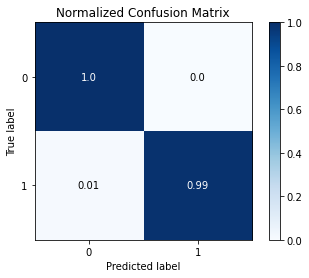

In [13]:
# get model predictions 
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]

print("Accuracy: %.2f%%" % (scores[1]*100))

print(metrics.classification_report(y_test, predictions, target_names=[ 'no moral appeal', 'moral apeal']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions , normalize=True)
plt.show()

In [14]:
save = pd.read_csv('./data/sample_moral_appeal.csv').drop(columns = 'Unnamed: 0')
save

,ad,moral_appeal
0,yearold danylo is not only battling cancer but...,1
1,learn how to use the new staffing law to impro...,0
2,we are live with climate activist anuna de wev...,0
3,did you miss the t summit relive the daylong e...,0
4,friday is north carolina’s online voter regist...,0
...,...,...
120,in just three months time they likely will be ...,0
121,we have until march st to raise money for our ...,0
122,ukraine needs your support\nany donation you p...,1
123,djibouti faces extreme water scarcity exacerba...,0


Accuracy: 68.80%
                 precision    recall  f1-score   support

no moral appeal       0.88      0.27      0.42        51
   moral appeal       0.66      0.97      0.79        74

       accuracy                           0.69       125
      macro avg       0.77      0.62      0.60       125
   weighted avg       0.75      0.69      0.64       125

confusion matrix:
[[14 37]
 [ 2 72]]



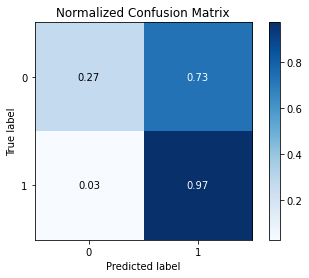

In [15]:
norm_ = save['ad']
test_ = t.texts_to_sequences(norm_)
padded_ = tf.keras.preprocessing.sequence.pad_sequences(test_, maxlen=MAX_SEQUENCE_LENGTH)

pred_ = model.predict(padded_)

save['predicted'] = [1 if prob > 0.5 else 0 for prob in pred_]

scores = model.evaluate(padded_, save['moral_appeal'], verbose =False)
print("Accuracy: %.2f%%" % (scores[1]*100))
print(metrics.classification_report(save['moral_appeal'], save['predicted'], target_names=[ 'no moral appeal', 'moral appeal']))
print("confusion matrix:")
print(metrics.confusion_matrix(save['moral_appeal'], save['predicted']))
print()

skplt.metrics.plot_confusion_matrix(save['moral_appeal'], save['predicted'], normalize=True)
plt.show()